# Selection of gene groups with predefined similarity
The notebook selects genes with close neighbours (hub genes; e.g. have at least N neighbours with similarity above S). It then retrieves all their neighbours above certain similarity (S). It merges these neighbourhoods if the minimal similarity betwen any of the elements in the merged neighbourhoods is above a threshold (e.g. minimal similarity within any of the starting groups).

In [3]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import library_regulons
reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
import deR.enrichment_library as enr
reload(enr)
import deR.enrichment_library as enr

In [41]:
#dataPath=module_path+'/data_expression/'
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [42]:
neighbour_calculator_all = NeighbourCalculator(genes=genes)

# Selection of hub genes and their neighbourhoods
Select genes that have at least MIN_NEIGH number of neighbours with similarity at least SIM. For these genes calculate 100 closest neighbours and retain those with similarity at least SIM - termed neighbourhoods.

In [44]:
SCALE = 'mean0std1'
LOG = True
#If hubs were filtered retain that many top ones
NHUBS = 500
#How many neighbours to initially calculate to get hubs, must be at least MIN_NEIGH+1 if non-opposite profiles
NEIGH_HUBS=6
#Similarity threshold for neighbours to hub
SIM=0.96
#Min neighbours a hub must have
MIN_NEIGH=NEIGH_HUBS-1

In [45]:
path_neighbours='/home/karin/Documents/timeTrajectories/data/regulons/clusters/merge_similarity/newGenes_kN6_m0s1log'

In [46]:
neigh_all, sims_all=loadPickle(path_neighbours+'_neighbours_sims.pkl')

How many hub genes would we get with different thresholds for number of neighbours a hub must have and their similarity.

In [47]:
print('Similarity threhold: 0.97, min neighbours: 5, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.97,
                                                                 min_neighbours=5)))
print('Similarity threhold: 0.97, min neighbours: 3, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.97,
                                                                 min_neighbours=3)))
print('Similarity threhold: 0.96, min neighbours: 5, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.96,
                                                                 min_neighbours=5)))
print('Similarity threhold: 0.96, min neighbours: 3, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.96,
                                                                 min_neighbours=3)))
print('Similarity threhold: 0.95, min neighbours: 5, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.95,
                                                                 min_neighbours=5)))
print('Similarity threhold: 0.95, min neighbours: 3, selected genes:',len(NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, 
                                                            similarity_threshold=0.95,
                                                                 min_neighbours=3)))


Similarity threhold: 0.97, min neighbours: 5, selected genes: 43
Similarity threhold: 0.97, min neighbours: 3, selected genes: 78
Similarity threhold: 0.96, min neighbours: 5, selected genes: 131
Similarity threhold: 0.96, min neighbours: 3, selected genes: 213
Similarity threhold: 0.95, min neighbours: 5, selected genes: 293
Similarity threhold: 0.95, min neighbours: 3, selected genes: 402


In [48]:
hubs_all= NeighbourCalculator.filter_similarities_matrix(similarities=sims_all, similarity_threshold=SIM,
                                                                 min_neighbours=MIN_NEIGH)
#hubs_all = NeighbourCalculator.find_hubs(similarities=sims_all.loc[hubs_all, :], n_hubs=NHUBS)

In [49]:
neigh_hubs, sims_hubs = neighbour_calculator_all.neighbours(n_neighbours=100, inverse=False, scale=SCALE,
                                                            log=LOG,
                                                            return_neigh_dist=True, genes_query_names=hubs_all)

In [50]:
neighbourhoods = NeighbourCalculator.hub_neighbours(neighbours=neigh_hubs, similarities=sims_hubs,
                                                    similarity_threshold=SIM)

# Characteristics of hub neighbourhoods
Remove duplicated neighbourhoods and those that are contained within other neighbourhoods.

Below: Distribution of neighbourhood sizes at start - directly from hub genes, which are added to their own neighbourhood.

N neighbourhoods at start: 131
Smallest neighbourhood: 6 , largest: 26


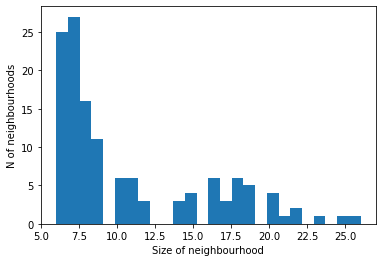

In [51]:
# Add hub to neighbourhood
neighbourhoods_merged=NeighbourhoodParser.add_hub_to_neigh(neighbourhoods=neighbourhoods)
print('N neighbourhoods at start:',len(neighbourhoods_merged))
NeighbourhoodParser.plot_size_distn_neighbourhoods(neighbourhoods_merged)

In [52]:
# Remove repeated neighborhoods
neighbourhoods_merged =NeighbourhoodParser.remove_repeated(neighbourhoods_merged)
print('N neighbourhoods after removing repeated (identical) neighbourhoods:',len(neighbourhoods_merged))
#plot_size_distn_neighbourhoods(neighbourhoods_merged)

N neighbourhoods after removing repeated (identical) neighbourhoods: 122


N neighbourhoods after removing contained neighbourhoods: 102
Smallest neighbourhood: 6 , largest: 26


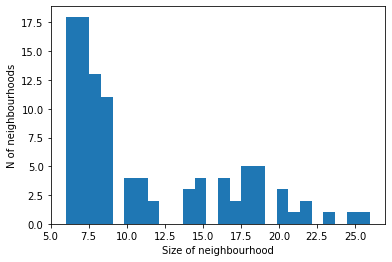

In [53]:
# Remove contained neighbourhoods. Assumes neighbourhoods are unique.
neighbourhoods_merged=NeighbourhoodParser.remove_contained(neighbourhoods_merged)
print('N neighbourhoods after removing contained neighbourhoods:',len(neighbourhoods_merged))
NeighbourhoodParser.plot_size_distn_neighbourhoods(neighbourhoods_merged)

In [54]:
neighbourhood_genes = list({gene for neigh_list in neighbourhoods_merged for gene in neigh_list})
print('N genes in neighbourhoods',len(neighbourhood_genes))

N genes in neighbourhoods 244


In [55]:
# Calculate cosine similarity between genes for later
genes_normalised = NeighbourCalculator.get_index_query(genes=genes.loc[neighbourhood_genes, :], inverse=False,
                                                       scale=SCALE, log=LOG)[0]
genes_cosine = pd.DataFrame(cosine_similarity(genes_normalised), index=neighbourhood_genes, columns=neighbourhood_genes)

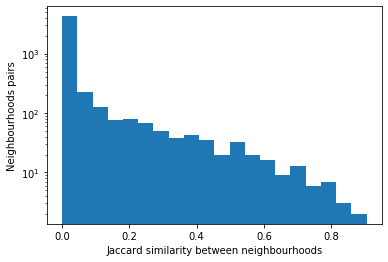

In [56]:
#Jaccard similarity
dist_arr_jaccard=NeighbourhoodParser.neighbourhood_distances(neighbourhoods=neighbourhoods_merged,
                                                    measure='jaccard')[0]

plt.hist(1-dist_arr_jaccard,bins=20)
plt.xlabel('Jaccard similarity between neighbourhoods')
plt.ylabel('Neighbourhoods pairs')
plt.yscale('log')

# Merge neighbourhoods
Merged if minimal similarity in the new neighbourhood is above some threshold. Merging is done based on the order of hierarchical clustering. Hierarchical clustering is currently based on percent of genes of smaller group that are within larger group.

In [57]:
# Distances between neighbourhoods
#For merging - proportion of genes from the smaller group contained in the larger group from a pair
dist_arr,node_neighbourhoods=NeighbourhoodParser.neighbourhood_distances(neighbourhoods=neighbourhoods_merged,
                                                    measure='percent_shared_smaller')

In [58]:
neigh_hc = hc.ward(dist_arr)

Use minimal similarity within any of the staring groups as thereshold for merging groups - merge if none of the similarities within the merged groups are below this thershold.

In [59]:
min_neighbourhood_similarity=NeighbourhoodParser.min_neighbourhood_similarity(neighbourhoods,genes_sims=genes_cosine)
print('Min similarity in any group before merging:',np.round(min_neighbourhood_similarity,3))

Min similarity in any group before merging: 0.898


In [60]:
node_neighbourhoods=NeighbourhoodParser.merge_by_hc(hc_result=neigh_hc,node_neighbourhoods=node_neighbourhoods,
                                                    genes_sims=genes_cosine,
                                                    min_group_sim=min_neighbourhood_similarity)

N merged neighbourhoods 63
Smallest neighbourhood: 6 , largest: 27


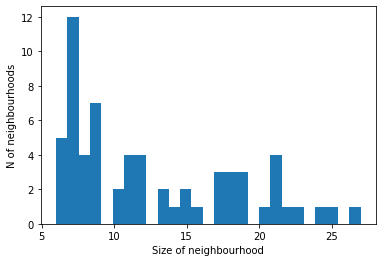

In [61]:
print('N merged neighbourhoods',len(node_neighbourhoods))
NeighbourhoodParser.plot_size_distn_neighbourhoods(list(node_neighbourhoods.values()))

Below: Jaccard similarities between merged neighbourhood groups - how big is the overlap.

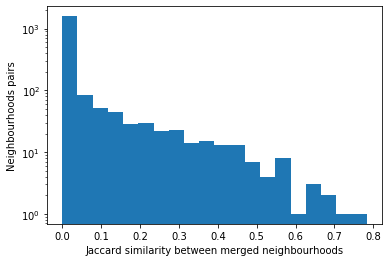

In [62]:
dist_arr_jaccard_merged=NeighbourhoodParser.neighbourhood_distances(neighbourhoods=list(node_neighbourhoods.values()),
                                                    measure='jaccard')[0]
plt.hist(1-dist_arr_jaccard_merged,bins=20)
plt.xlabel('Jaccard similarity between merged neighbourhoods')
plt.ylabel('Neighbourhoods pairs')
plt.yscale('log')

Above shown jaccard similarities are for all neighbourhood pairs. Distribution of similarities to the closest neighbourhood is shifted to higher similarities (below).

Text(0, 0.5, 'N neighbourhoods')

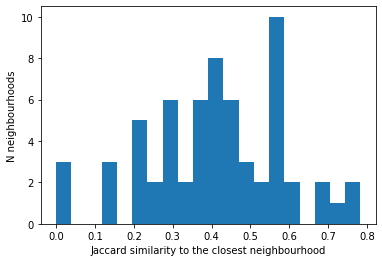

In [63]:
idx=np.triu_indices(len(node_neighbourhoods),k=1)
group_names=list(node_neighbourhoods.keys())
dist_arr_jaccard_merged_df=pd.DataFrame(index=group_names,columns=group_names)
for sim,j,i in zip(1-dist_arr_jaccard_merged,idx[0],idx[1]):
    j=group_names[j]
    i=group_names[i]
    dist_arr_jaccard_merged_df.loc[j,i]=sim
    dist_arr_jaccard_merged_df.loc[i,j]=sim
plt.hist(dist_arr_jaccard_merged_df.max(),bins=20)
plt.xlabel('Jaccard similarity to the closest neighbourhood')
plt.ylabel('N neighbourhoods')

Below: In how many neighbourhoods is each gene present

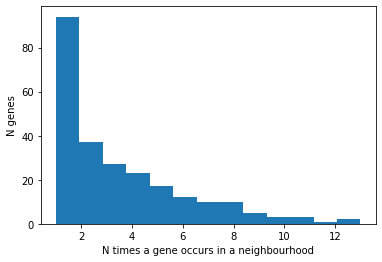

In [64]:
# How many times does each gene occur in clusters
gene_occurence=Counter(gene for neighbourhood in node_neighbourhoods.values() for gene in neighbourhood)
gene_counts=gene_occurence.values()
plt.hist(gene_counts,bins=max(gene_counts))
plt.xlabel('N times a gene occurs in a neighbourhood')
plt.ylabel('N genes')
group_unique_genes={gene for gene,count in gene_occurence.items() if count==1}

Dendrogram for ordering of neighbourhood merging. Neighbourhood nodes that were merged are marked with red dots. The above count of groups consists of both merged (red dots) and unmerged (leaf nodes without red dot above) groups. The hierarchical clustering is based on percent of genes of smaller group that are contained in larger group.

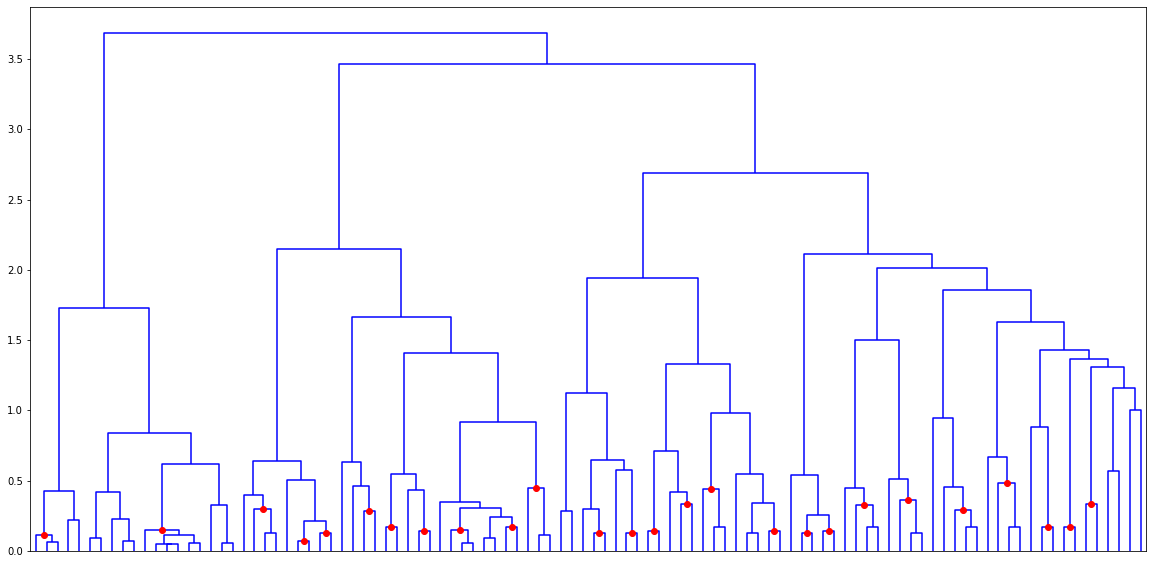

In [65]:
#From: https://stackoverflow.com/questions/43513698/relation-between-dendrogram-plot-coordinates-and-clusternodes-in-scipy
plt.figure(figsize=(20,10))
dend=hc.dendrogram(neigh_hc,color_threshold=0,no_labels=True)
def flatten(l):
    return [item for sublist in l for item in sublist]
X = flatten(dend['icoord'])
Y = flatten(dend['dcoord'])
leave_coords = [(x,y) for x,y in zip(X,Y) if y==0]

# in the dendogram data structure,
# leave ids are listed in ascending order according to their x-coordinate
order = np.argsort([x for x,y in leave_coords])
id_to_coord = dict(zip(dend['leaves'], [leave_coords[idx] for idx in order])) # <- main data structure

# map endpoint of each link to coordinates of parent node
children_to_parent_coords = dict()
for i, d in zip(dend['icoord'], dend['dcoord']):
    x = (i[1] + i[2]) / 2
    y = d[1] # or d[2]
    parent_coord = (x, y)
    left_coord = (i[0], d[0])
    right_coord = (i[-1], d[-1])
    children_to_parent_coords[(left_coord, right_coord)] = parent_coord

# traverse tree from leaves upwards and populate mapping ID -> (x,y)
root_node, node_list = hc.to_tree(neigh_hc, rd=True)
ids_left = range(len(dend['leaves']), len(node_list))

while len(ids_left) > 0:

    for ii, node_id in enumerate(ids_left):
        node = node_list[node_id]
        if (node.left.id in id_to_coord) and (node.right.id in id_to_coord):
            left_coord = id_to_coord[node.left.id]
            right_coord = id_to_coord[node.right.id]
            id_to_coord[node_id] = children_to_parent_coords[(left_coord, right_coord)]

    ids_left = [node_id for node_id in range(len(node_list)) if not node_id in id_to_coord]

# plot result on top of dendrogram
ax = plt.gca()
for node_id, (x, y) in id_to_coord.items():
    if not node_list[node_id].is_leaf():
        if node_id in node_neighbourhoods.keys():
            ax.plot(x, y, 'ro')
        
        #ax.annotate(str(node_id), (x, y), xytext=(0, -8),textcoords='offset points',va='top', ha='center')

dend['node_id_to_coord'] = id_to_coord


### Gene set enrichment
Uses KEGG, Dicty and GO (only generic slims).

In [66]:
gene_sets=list(list_all(organism='44689'))
gene_sets_ontology=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True)

In [67]:
all_gene_names=neighbour_calculator_all._genes.index
name_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
all_gene_names_EID=enr.convert_EID(genes=all_gene_names, name_EID=name_EID)

In [68]:
enriched=dict()
for name,neighbourhood in node_neighbourhoods.items():
    query_EID=enr.convert_EID(genes=neighbourhood, name_EID=name_EID)
    if len(query_EID) > 0:
        enriched[name]=enr.gene_set_enrichment(query_EID, reference_EID=all_gene_names_EID, 
                                                padj_threshold=0.1,output='name_ontology',
                                                gene_sets_ontology=gene_sets_ontology)

In [69]:

parsed=[]
for group,group_genes in node_neighbourhoods.items():
    enriched_group=''
    append_enriched=''
    if group in enriched.keys():
        enrichment_group=enriched[group]
        if len(enrichment_group)>0:
            if len(enrichment_group)>5:
                append_enriched='\n'+str(len(enrichment_group)-5)+' more'
            enriched_group=ClusteringAnalyser.parse_enrichment_dict( 
                dict([(k[1][0][0]+k[1][1][0]+': '+ k[0], v) for k, v in sorted(enrichment_group.items(), key=lambda item: item[1])][:5]))
    parsed.append({'Group':group,'N genes':len(group_genes),
                   'Proportion unique genes':np.round(len(group_unique_genes.intersection(group_genes))/len(group_genes),2),
                   'Enriched':enriched_group+append_enriched})
parsed=pd.DataFrame(parsed)    

Table legend:
- Group: ID of group
- N genes: N of genes in group
- Proportion unique genes: Proptotion of genes in group that are not within any other group. Table is sorted based on this.
- Enriched: Enriched gene sets. First component is ontology abbreviation  (DP - dictyBase Phenotypes, KP - KEGG Pathways, Gm - GO molecular function, Gc - GO cellular component, Gb - GO biological process), second component is gene set name and last component is FDR.

In [70]:
pd.options.display.latex.repr = True

In [71]:
jf.display_newline_df(parsed.sort_values('Proportion unique genes',ascending=False))

Group,N genes,Proportion unique genes,Enriched
134,9,1.00,KP: Proteasome: 8.195E-23Gm: peptidase activity: 2.003E-13Gc: protein-containing complex: 1.288E-11Gb: catabolic process: 1.070E-10Gc: nucleus: 5.656E-087 more
70,7,1.00,
42,7,1.00,
133,8,0.75,
19,7,0.71,
150,12,0.67,Gb: anatomical structure development: 9.755E-02DP: increased slug migration: 9.755E-02DP: aberrant regulation of GTPase activity: 9.755E-02DP: decreased basal F-actin level: 9.755E-02DP: aberrant sorting to prestalk region: 9.755E-02
5,9,0.33,
7,6,0.33,Gc: ribosome: 4.515E-12Gm: structural constituent of ribosome: 1.192E-09KP: Ribosome: 1.560E-09Gm: structural molecule activity: 3.037E-09Gc: protein-containing complex: 1.282E-0719 more
153,18,0.33,Gb: extracellular matrix organization: 8.547E-02DP: abolished cellulose biosynthesis: 8.547E-02DP: aberrant stalk formation: 8.547E-02DP: abolished stalk formation: 8.547E-02Gc: extracellular matrix: 9.098E-021 more
64,6,0.33,Gc: ribosome: 1.615E-12Gm: structural constituent of ribosome: 1.615E-12KP: Ribosome: 1.615E-12Gm: structural molecule activity: 3.833E-12Gb: translation: 2.600E-1117 more


In [72]:
# Save result for Orange
NeighbourhoodParser.parse_orange(node_neighbourhoods).to_csv(
    path_neighbours+'_sim'+str(SIM)+'_minkN'+str(MIN_NEIGH)+'_neighbourhoods.tsv',
                                        sep='\t',index=False)
pd.DataFrame(neighbourhood_genes,columns=['Gene']).to_csv(
    path_neighbours+'_sim'+str(SIM)+'_minkN'+str(MIN_NEIGH)+'_neighbourhood_genes.tsv',
                                        sep='\t',index=False)